In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
from tqdm import tqdm

BATCH_SIZE = 64
LR = 0.001
NUM_OF_EPOCHES = 10
LATENT_DIM = 10
MLP_TRAIN_SIZE = 45


def get_dataset(batch=BATCH_SIZE, shuffle_train = True):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Pad(2),
         transforms.Normalize((0.5), (0.5))])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=shuffle_train)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, testloader


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(nn.Linear(LATENT_DIM, 128),
                                nn.ReLU(True),
                                nn.Linear(128, 192),)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 6, stride=2, padding=1),  # b, 1, 32, 32
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = self.decoder(x.reshape(x.shape[0], 48, 2, 2))
        return x





class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(64, 48, 2, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 8, 2, 2
            nn.Flatten(1),
            nn.Linear(192, 128),
            nn.ReLU(True),
            nn.Linear(128, LATENT_DIM),
        )

        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

    def get_latent_vector(self):
        return self.encoder[-1].weight.detach()


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 32, 32)
    return x

In [3]:
def train_nn(nn_net, trainloader, testloader, criterion, optimizer, net_name):
    accuracy = torchmetrics.Accuracy()
    ROC = torchmetrics.AUC(reorder=True)
    F1 = torchmetrics.F1()
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []
    train_roc, test_roc = [], []
    train_f1, test_f1 = [], []
    for epoch in tqdm(range(NUM_OF_EPOCHES)):  # loop over the dataset multiple times

        running_loss = 0.0
        acc, roc, f1 = 0.0, 0.0, 0.0
        counter = 0
        for i, data in enumerate(trainloader, 0):
            counter += 1
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = nn_net(inputs)
            if net_name in ["MLP", "ENCODER+MLP", ""]:
                loss = criterion(outputs, labels)
                match_args = torch.argmax(torch.exp(outputs), 1)
                acc += accuracy(match_args, labels)
                # print(ROC(match_args, labels))
                roc += ROC(match_args, labels)
                f1 += F1(match_args, labels)
            else:
                loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # running_acc += (inputs.eq(outputs.long())).sum().item() / (inputs.shape[0] * 32 * 32)
            # if i % BATCH_SIZE == BATCH_SIZE:    # print every 2000 mini-batches
            if net_name in ["MLP", "ENCODER+MLP"]:
                break
        train_loss.append(running_loss / counter)
        train_acc.append(acc / counter)
        train_roc.append(roc / (counter * 100))
        train_f1.append(f1 / counter)

        running_loss = 0.0
        acc, roc, f1 = 0.0, 0.0, 0.0
        counter = 0

        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                counter += 1
                images, labels = data
                # calculate outputs by running images through the network
                outputs = nn_net(images)
                # the class with the highest energy is what we choose as prediction
                # _, predicted = torch.max(outputs.data, 1)
                # total += inputs.size(0)
                # correct += (predicted == labels).sum().item()
                if net_name in ["MLP", "ENCODER+MLP", ""]:
                    loss = criterion(outputs, labels)
                    match_args = torch.argmax(torch.exp(outputs), 1)
                    acc += accuracy(match_args, labels)
                    # print(ROC(match_args, labels))
                    roc += ROC(match_args, labels)
                    f1 += F1(match_args, labels)
                else:
                    loss = criterion(outputs, images)
                running_loss += loss.item()
                # running_acc += (images.eq(outputs.long())).sum().item() / (images.shape[0] * 32 * 32)
                # if counter == 1:
                #     pic1 = to_img(outputs.cpu().data)
                #     pic2 = to_img(images.cpu().data)
                #     torchvision.utils.save_image(pic1, f'./results/got_{epoch}.png')
                #     torchvision.utils.save_image(pic2, f'./results/original_{epoch}.png')
                # if net_name in ["MLP", "ENCODER+MLP"]:
                #     break
        test_loss.append(running_loss / counter)
        test_acc.append(acc / counter)
        test_roc.append(roc / (counter * 100))
        test_f1.append(f1 / counter)
        # test_acc.append(running_acc / counter)

        # print('Accuracy of the network on the 10000 test images: %d %%' % (
        #         100 * correct / total))


    plt.title(net_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(train_loss, label=f'train loss')
    plt.plot(test_loss, label=f'test loss')
    plt.legend()
    plt.savefig(f'{net_name}_d={LATENT_DIM}_loss.png')
    plt.show()

    if net_name in ["MLP", "ENCODER+MLP"]:
        plt.title(net_name)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(train_acc, label=f'train')
        plt.plot(test_acc, label=f'test')
        plt.legend()
        plt.savefig(f'{net_name}_d={LATENT_DIM}_acc.png')
        plt.show()

        # plt.title(net_name)
        # plt.xlabel('Epoch')
        # plt.ylabel('ROC')
        # plt.plot(train_roc, label=f'train')
        # plt.plot(test_roc, label=f'test')
        # plt.legend()
        # plt.savefig(f'{net_name}_d={LATENT_DIM}_auc.png')
        # plt.show()

        # plt.title(net_name)
        # plt.xlabel('Epoch')
        # plt.ylabel('F1')
        # plt.plot(train_f1, label=f'train')
        # plt.plot(test_f1, label=f'test')
        # plt.legend()
        # plt.savefig(f'{net_name}_d={LATENT_DIM}_f1.png')
        # plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 10/10 [06:00<00:00, 36.06s/it]


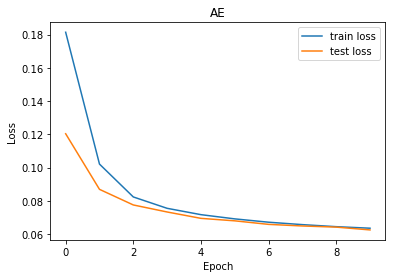

In [18]:
# Question 1:

net = AutoEncoder()
crit = nn.MSELoss()
opt = optim.Adam(net.parameters(), lr=LR)

tr_loader, tst_loader = get_dataset()

# train_acc, test_acc = [], []
train_nn(net, tr_loader, tst_loader, crit, opt, "AE")
torch.save(net.state_dict(), f'autoencoder_d={LATENT_DIM}.pt')

In [4]:
def load_model(latent_dim=LATENT_DIM):
    model = AutoEncoder()
    model.load_state_dict(torch.load(f'autoencoder_d={latent_dim}.pt'))
    # model.eval()
    return model

[1.3554491970996991, 1.7081624029072535, 2.6489278764535227, 3.1520129426490184]


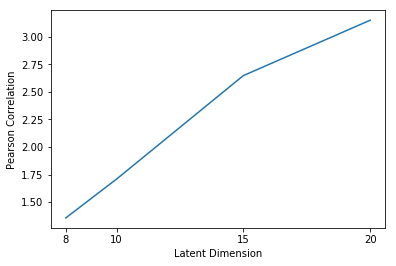

In [20]:
# Question 2:

correlations = []
saved_ae = [8, 10, 15, 20]
tr_loader, tst_loader = get_dataset(6000, shuffle_train=False)
images = None
for data in tr_loader:
    images, _ = data
    break

prev_latent = LATENT_DIM
for i in saved_ae:
    LATENT_DIM = i
    model = load_model(i)
    loaded_encoder = model.encoder
    # latent_codes = torch.zeros((3300, i))
    counter = 0
    with torch.no_grad():
        output = loaded_encoder(images)
        pearson_corr = np.corrcoef(output.numpy().T)
        # extract the upper triangle without th diagonal
        corr = np.linalg.norm(pearson_corr[np.triu_indices_from(pearson_corr, k=1)])
        correlations.append(corr)

print(correlations)
plt.xlabel('Latent Dimension')
plt.ylabel('Pearson Correlation')
plt.plot(saved_ae, correlations)
plt.xticks(saved_ae)
plt.savefig('correlation.png')
plt.show()
LATENT_DIM = prev_latent



In [4]:

class MLP_AE(nn.Module):
    def __init__(self, encoder):
        super(MLP_AE, self).__init__()
        self.encoder = encoder
        self.mlp = nn.Sequential(nn.Linear(LATENT_DIM, 30),
                                 nn.ReLU(),
                                 nn.Linear(30, 20),
                                 nn.ReLU(),
                                 nn.Linear(20, 10),
                                 # # nn.ReLU(),
                                 # nn.Linear(20, 10),
                                 nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.mlp(x)
        return x


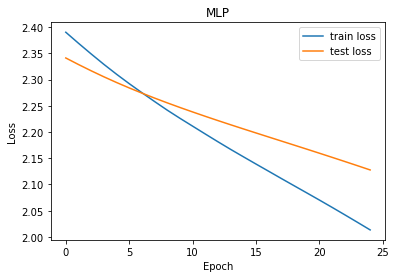

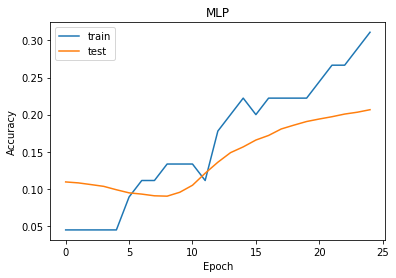

In [80]:
# Question 3:

# Transfer Learning
encoder = load_model().encoder
for param in encoder.parameters():
    param.requires_grad = False
mlp_net = MLP_AE(encoder)
tr_loader, tst_loader = get_dataset(MLP_TRAIN_SIZE, shuffle_train=False)
crit = nn.NLLLoss()
opt = optim.Adam(mlp_net.parameters(), lr=LR)
train_nn(mlp_net, tr_loader, tst_loader, crit, opt, "MLP")

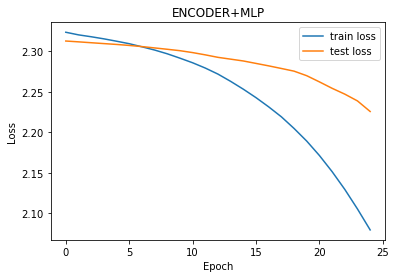

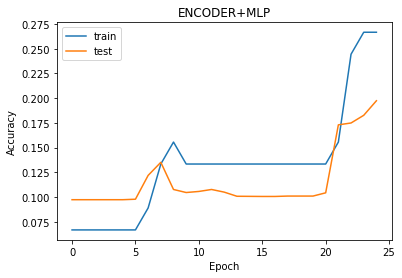

In [81]:
# Without transfer
n = AutoEncoder()
encoder = n.encoder
mlp_net = MLP_AE(encoder)
# tr_loader, tst_loader = get_dataset(MLP_TRAIN_SIZE)
crit = nn.NLLLoss()
opt = optim.Adam(mlp_net.parameters(), lr=LR)
train_nn(mlp_net, tr_loader, tst_loader, crit, opt, "ENCODER+MLP")

In [5]:
GAN_BATCH = 128
GAN_LR = 0.001
GAN_LATENT_DIM = 52
GAN_EPOCHES = 50

class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.mlp = nn.Sequential(nn.Linear(GAN_LATENT_DIM, 252),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(252, 128),
                                 nn.BatchNorm1d(128),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(128, 64),
                                 nn.BatchNorm1d(64),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(64, 32),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(32, LATENT_DIM))

    def forward(self, x):
        return self.mlp(x)


class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(nn.Linear(LATENT_DIM, 128),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(128, 64),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(64, 32),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(32, 16),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(16, 1),
                                  nn.Sigmoid())
    def forward(self, x):
        return self.main(x)


def get_fake_images(output_shape):
    return torch.normal(0, 1, (output_shape, GAN_LATENT_DIM))

def get_fake_labels(output_shape):
    return torch.zeros((output_shape, 1))

def get_real_labels(output_shape):
    return torch.ones((output_shape, 1))


wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
100%|██████████| 50/50 [22:29<00:00, 26.99s/it]


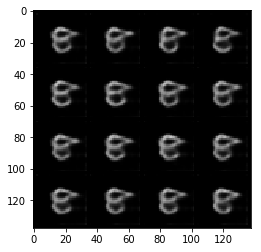

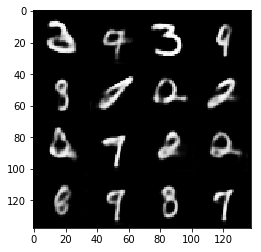

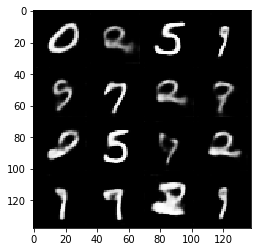

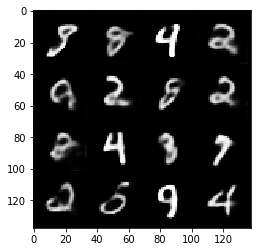

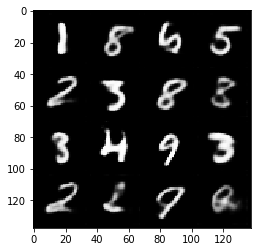

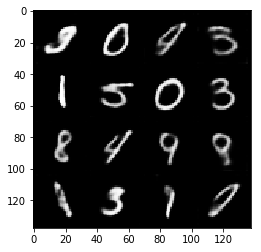

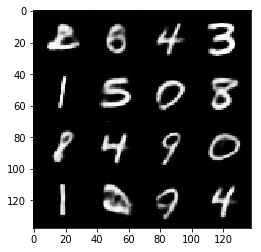

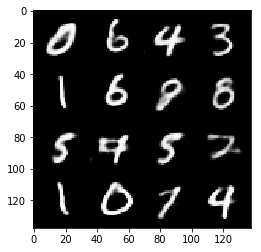

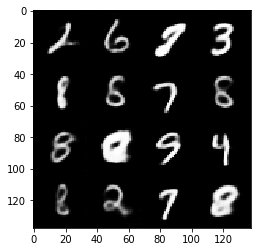

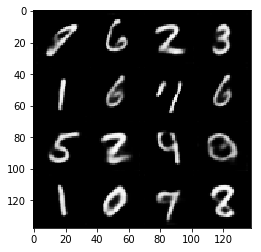

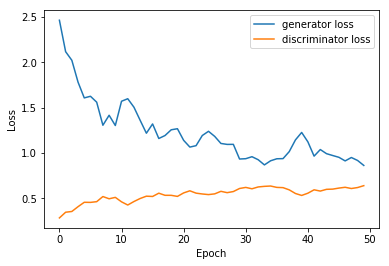

In [7]:
from tqdm import tqdm
import random
import wandb

wandb.init(project=f"gan_lr={GAN_LR}_batch={GAN_BATCH}_d={LATENT_DIM}")

encoder = load_model(LATENT_DIM).encoder
discriminator_net = discriminator()
generator_net = generator()

crit_generator = nn.BCELoss()
crit_discriminator = nn.BCELoss()
discriminator_opt = optim.Adam(discriminator_net.parameters(), lr=GAN_LR)
generator_opt = optim.Adam(generator_net.parameters(), lr=GAN_LR)

tr_set, _ = get_dataset(GAN_BATCH)
data_length = len(tr_set)

generator_loss = []
discriminator_loss = []

image_for_testing = get_fake_images(16)
decoder = load_model().decoder

for epoch in tqdm(range(GAN_EPOCHES)):

    d_loss, g_loss = 0.0, 0.0

    if epoch % 5 == 0:
        with torch.no_grad():
            mid_test = decoder(generator_net(image_for_testing))
            test_result = to_img(mid_test)
            plt.imshow(torchvision.utils.make_grid(test_result, nrow=4).permute(1, 2, 0))
            plt.show()

    # train the discriminator
    # random.shuffle(fake_generator)
    for real_data in tr_set:
        real_images, _ = real_data
        b_size = real_images.shape[0]
        true_labels = get_real_labels(b_size)

        fake_images = generator_net(get_fake_images(b_size))
        false_labels = get_fake_labels(b_size)

        discriminator_opt.zero_grad()

        images = torch.vstack([encoder(real_images), fake_images])
        labels = torch.vstack([true_labels, false_labels])
        d_out = discriminator_net(images)
        loss = crit_discriminator(d_out, labels)
        loss.backward()

        discriminator_opt.step()
        d_loss += loss.item()

        ### train generator
        generator_opt.zero_grad()

        fake_images = get_fake_images(b_size)
        g_labels = get_real_labels(b_size)

        g_out = discriminator_net(generator_net(fake_images))
        loss = crit_generator(g_out, g_labels)

        loss.backward()
        generator_opt.step()

        g_loss += loss.item()



    discriminator_loss.append(d_loss / data_length)
    generator_loss.append(g_loss / data_length)
    wandb.log({'discriminator loss': discriminator_loss[-1], 'generator loss': generator_loss[-1]})


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(generator_loss, label=f'generator loss')
plt.plot(discriminator_loss, label=f'discriminator loss')
plt.legend()
plt.savefig('gan_result.png')
plt.show()



In [8]:
torch.save(generator_net.state_dict(), f'generator_d={LATENT_DIM}.pt')
torch.save(discriminator_net.state_dict(), f'discriminator_d={LATENT_DIM}.pt')

In [6]:
generator_net = generator()
generator_net.load_state_dict(torch.load(f'generator_d={LATENT_DIM}.pt'))

<All keys matched successfully>

In [9]:
decoder = load_model(LATENT_DIM).decoder
fake_image = get_fake_images(64)
result_image = generator_net(fake_image)
image = to_img(decoder(result_image))
torchvision.utils.save_image(image, f'./results/gan_result.png')



In [10]:
network = load_model(LATENT_DIM)
tr_set, _ = get_dataset(64)
for d in tr_set:
    images, _ = d
    break

image = to_img(network(images))
torchvision.utils.save_image(image, f'./results/ae_results.png')

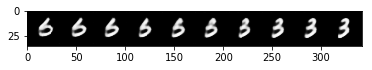

torch.Size([3, 70, 342])
torch.Size([3, 70, 342])
torch.Size([3, 70, 342])
torch.Size([3, 70, 342])
torch.Size([3, 70, 342])


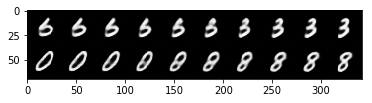

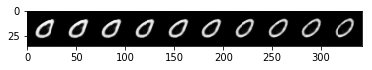

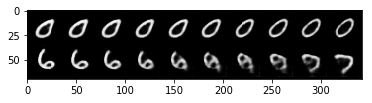

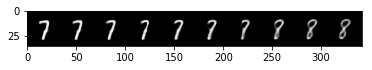

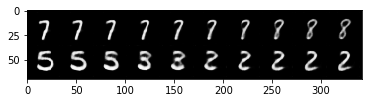

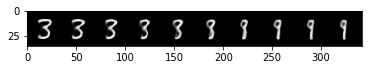

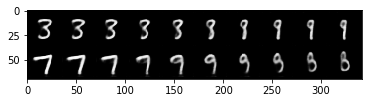

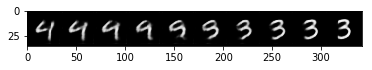

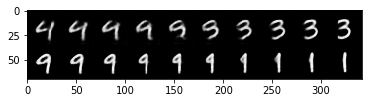

In [19]:
encoder = load_model().encoder

# Question 4 - part 2 (interpolating)
def calc_inter(img1, img2, a):
    return (a * img1) + ((1 - a) * img2)


for i in range(5):
    tr_set, _ = get_dataset(2)
    real1, real2 = None, None
    for d in tr_set:
        imgs, lbls = d
        if lbls[0] != lbls[1]:
            real1 = imgs[0].reshape(1, 1, 32, 32)
            real2 = imgs[1].reshape(1, 1, 32, 32)
            break

    with torch.no_grad():
        result =  generator_net(get_fake_images(100))
        fake1 = result[0].reshape(1, -1)
        fake2 = result[1].reshape(1, -1)

    real1 = encoder(real1)
    real2 = encoder(real2)

    fake_results = [decoder(calc_inter(fake1, fake2, alpha)) for alpha in np.arange(0, 1, 0.1)]
    real_results = [decoder(calc_inter(real1, real2, alpha)) for alpha in np.arange(0, 1, 0.1)]


    stack_real = torch.vstack(real_results)
    stack_fake = torch.vstack(fake_results)
    results = torch.vstack([stack_fake, stack_real])
    images_concat = to_img(results)

    tmp = to_img(stack_fake)
    plt.imshow(torchvision.utils.make_grid(tmp, nrow=10).permute(1, 2, 0))
    plt.show()
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    print(grid_img.shape)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    # torchvision.utils.save_image(grid_img.permute(1, 2, 0), f'./results/interpolations.png')






wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
100%|██████████| 10/10 [02:09<00:00, 12.96s/it]


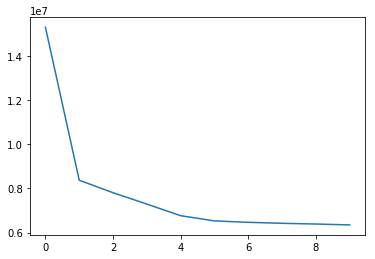

In [40]:
# import wandb
#
# wandb.init(project=f"cgan_lr={GAN_LR}_batch={GAN_BATCH}_d={LATENT_DIM}")
#
# num_classifier = mlp_net.mlp
# for param in num_classifier.parameters():
#     param.requires_grad = False
# class input_generator(nn.Module):
#     def __init__(self, generator, classifier):
#         super(input_generator, self).__init__()
#         self.condition_layer = nn.Sequential(nn.Linear(10, 32),
#                                              nn.LeakyReLU(0.2),
#                                              nn.Linear(32, 64),
#                                              nn.LeakyReLU(0.2),
#                                              nn.Linear(64, GAN_LATENT_DIM // 2))
#         self.noise_manipulation = nn.Sequential(nn.Linear(GAN_LATENT_DIM, 32),
#                                              nn.LeakyReLU(0.2),
#                                              nn.Linear(32, 64),
#                                              nn.LeakyReLU(0.2),
#                                              nn.Linear(64, GAN_LATENT_DIM // 2))
#         # self.activation = nn.LeakyReLU(0.2)
#         self.embedding = nn.Sequential(nn.Linear(GAN_LATENT_DIM, 256),
#                                        nn.LeakyReLU(0.2),
#                                        nn.Linear(256, 128),
#                                        nn.LeakyReLU(0.2),
#                                        nn.Linear(128 , GAN_LATENT_DIM))
#
#         self.classifier = classifier
#         self.generator = generator
#         # for param in self.generator.parameters():
#         #     param.requires_grad = False
#
#
#     def forward(self, condition):
#         x = self.condition_layer(condition)
#         noise = self.noise_manipulation(get_fake_images(condition.shape[0]))
#         condition_with_noise = torch.cat([x, noise], dim=1)
#         embedded = self.embedding(condition_with_noise)
#         # x += get_fake_images(x.shape[0])
#         x = self.generator(embedded)
#         x = self.classifier(x)
#         return x
#
# specific_gan = input_generator(generator_net, num_classifier)
# tr_set, tst_set = get_dataset(128)
# crit = nn.NLLLoss()
# opt = optim.AdamW(specific_gan.parameters(), lr=0.0001)
#
# losses = []
# for epoch in tqdm(range(10)):
#     l = 0.0
#     for d in tr_set:
#         images, labels = d
#
#         crit.zero_grad()
#         # encoded_img = encoder(images)
#         labels_hot = torch.zeros(images.shape[0], 10)
#         for i in range(images.shape[0]):
#             labels_hot[i, labels[i]] = 1
#         output = specific_gan(labels_hot.float())
#
#         loss = crit(output, labels)
#
#         loss.backward()
#         opt.step()
#         l += loss.item()
#     losses.append(l / len(tr_set))
#     wandb.log({'loss': losses[-1]})
#
# plt.plot(losses)
# plt.show()

In [44]:
encoder = network.encoder
for param in encoder.parameters():
    param.requires_grad = False
mlp_net = MLP_AE(encoder)
tr_loader, tst_loader = get_dataset()
crit = nn.NLLLoss()
opt = optim.Adam(mlp_net.parameters(), lr=LR)
train_nn(mlp_net, tr_loader, tst_loader, crit, opt, "")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
  0%|          | 0/10 [00:14<?, ?it/s]


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

In [45]:

class conditional_generator(nn.Module):
    def __init__(self):
        super(conditional_generator, self).__init__()
        self.condition = nn.Linear(10, GAN_LATENT_DIM // 2)
        self.noise = nn.Linear(GAN_LATENT_DIM, GAN_LATENT_DIM // 2)
        self.mlp = nn.Sequential(nn.Linear(GAN_LATENT_DIM, 252),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(252, 128),
                                 nn.BatchNorm1d(128),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(128, 64),
                                 nn.BatchNorm1d(64),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(64, 32),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(32, LATENT_DIM))


    def forward(self, condition):
        condition = self.condition(condition)
        noise = self.noise(get_fake_images(condition.shape[0]))
        x = torch.cat([condition, noise], dim=1)
        x = self.mlp(x)
        return x

class conditional_discriminator(nn.Module):
    def __init__(self):
        super(conditional_discriminator, self).__init__()
        self.condition = nn.Linear(10, LATENT_DIM)
        self.main = nn.Sequential(nn.Linear(LATENT_DIM * 2, 128),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(128, 64),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(64, 32),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(32, 16),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(16, 1),
                                  nn.Sigmoid())

    def forward(self, latent_code, condition):
        condition = self.condition(condition)
        x = torch.cat([condition, latent_code], dim=1)
        x = self.main(x)
        return x

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
100%|██████████| 50/50 [26:50<00:00, 32.21s/it]


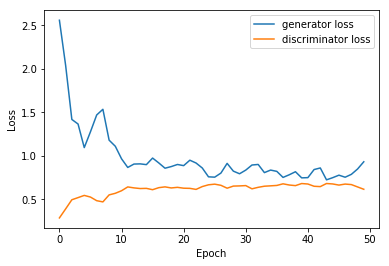

In [50]:
from tqdm import tqdm
import wandb

def get_one_hot(_labels):
    l_hot = torch.zeros(_labels.shape[0], 10)
    for i in range(_labels.shape[0]):
        l_hot[i, _labels[i]] = 1
    return l_hot

def generate_fake_labels(num_of_labels):
    return get_one_hot(np.random.randint(10, size=num_of_labels))


wandb.init(project=f"cgan_lr={GAN_LR}_batch={GAN_BATCH}_d={LATENT_DIM}")

encoder = load_model(LATENT_DIM).encoder
discriminator_net = conditional_discriminator()
generator_net = conditional_generator()

crit_generator = nn.BCELoss()
crit_discriminator = nn.BCELoss()
discriminator_opt = optim.Adam(discriminator_net.parameters(), lr=GAN_LR)
generator_opt = optim.Adam(generator_net.parameters(), lr=GAN_LR)

tr_set, _ = get_dataset(GAN_BATCH)
data_length = len(tr_set)

generator_loss = []
discriminator_loss = []


for epoch in tqdm(range(GAN_EPOCHES)):

    d_loss, g_loss = 0.0, 0.0

    # train the discriminator
    # random.shuffle(fake_generator)
    for real_data in tr_set:
        real_images, real_labels = real_data
        b_size = real_images.shape[0]
        true_labels = get_real_labels(b_size)

        fake_labels = generate_fake_labels(b_size)
        fake_images = generator_net(fake_labels)
        false_labels = get_fake_labels(b_size)

        discriminator_opt.zero_grad()

        images = torch.vstack([encoder(real_images), fake_images])
        d_labels = torch.vstack([true_labels, false_labels])
        d_out = discriminator_net(images, torch.vstack([get_one_hot(real_labels), fake_labels]))
        loss = crit_discriminator(d_out, d_labels)
        loss.backward()

        discriminator_opt.step()
        d_loss += loss.item()

        ### train generator
        generator_opt.zero_grad()

        fake_labels = get_fake_labels(b_size)
        g_labels = get_real_labels(b_size)
        fake_labels = generate_fake_labels(b_size)
        g_out = discriminator_net(generator_net(fake_labels), fake_labels)
        loss = crit_generator(g_out, g_labels)

        loss.backward()
        generator_opt.step()

        g_loss += loss.item()



    discriminator_loss.append(d_loss / data_length)
    generator_loss.append(g_loss / data_length)
    wandb.log({'discriminator loss': discriminator_loss[-1], 'generator loss': generator_loss[-1]})


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(generator_loss, label=f'generator loss')
plt.plot(discriminator_loss, label=f'discriminator loss')
plt.legend()
plt.savefig('cgan_result.png')
plt.show()

torch.save(generator_net.state_dict(), f'cgenerator_d={LATENT_DIM}.pt')
torch.save(discriminator_net.state_dict(), f'cdiscriminator_d={LATENT_DIM}.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


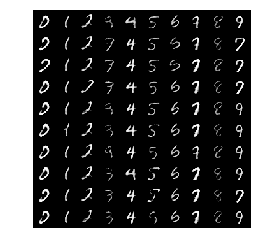

In [81]:
# show Q5 results

labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 10)
labels_hot = get_one_hot(labels)

results = generator_net(labels_hot)

images = decoder(results)
# torchvision.utils.save_image(to_img(images), f'./results/specific_gan.png')
grid_img = torchvision.utils.make_grid(to_img(images), nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.savefig('cgan_results.png', dpi=300, bbox_inches='tight',transparent=True, pad_inches=0)